In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)



In [2]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
interactions = pd.read_csv('interactions.csv')
sample_sub = pd.read_csv('sample_submission_file.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Interactions shape: {interactions.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

Train shape: (67200, 4)
Test shape: (5900, 4)
Interactions shape: (1048575, 11)
Sample submission shape: (5900, 2)


In [3]:
train['service_date'] = pd.to_datetime(train['service_date'], format='%d-%m-%Y')
test['service_date'] = pd.to_datetime(test['service_date'], format='%d-%m-%Y')
interactions['service_date'] = pd.to_datetime(interactions['service_date'], format='%d-%m-%Y')
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'], format='%d-%m-%Y')


print(f"Train: {train['service_date'].min()} to {train['service_date'].max()}")
print(f"Test: {test['service_date'].min()} to {test['service_date'].max()}")
print(f"Interactions: {interactions['interaction_date'].min()} to {interactions['interaction_date'].max()}")

Train: 2023-03-01 00:00:00 to 2024-12-31 00:00:00
Test: 2025-01-01 00:00:00 to 2025-02-28 00:00:00
Interactions: 2023-01-30 00:00:00 to 2024-02-01 00:00:00


In [4]:

print("Train missing values:\n", train.isnull().sum())
print("\nTest missing values:\n", test.isnull().sum())
print("\nInteractions missing values:\n", interactions.isnull().sum())

Train missing values:
 service_date           0
origin_hub_id          0
destination_hub_id     0
final_service_units    0
dtype: int64

Test missing values:
 service_key           0
service_date          0
origin_hub_id         0
destination_hub_id    0
dtype: int64

Interactions missing values:
 service_date                   0
interaction_date               0
origin_hub_id                  0
destination_hub_id             0
origin_region                  0
destination_region             0
origin_hub_tier                0
destination_hub_tier           0
cumulative_commitments         0
cumulative_interest_signals    0
days_before_service            0
dtype: int64


TARGET VARIABLE ANALYSIS
count    67200.000000
mean      2001.729464
std       1194.711140
min          2.000000
25%       1252.000000
50%       1685.000000
75%       2408.000000
max      13503.000000
Name: final_service_units, dtype: float64


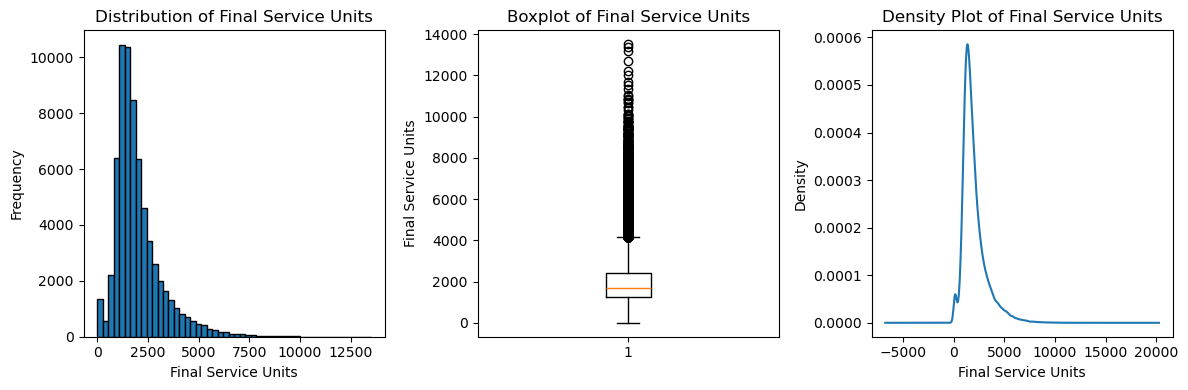

In [5]:
# Analyze target variable

print("TARGET VARIABLE ANALYSIS")
print(train['final_service_units'].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train['final_service_units'], bins=50, edgecolor='black')
plt.title('Distribution of Final Service Units')
plt.xlabel('Final Service Units')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(train['final_service_units'])
plt.title('Boxplot of Final Service Units')
plt.ylabel('Final Service Units')

plt.subplot(1, 3, 3)
train['final_service_units'].plot(kind='density')
plt.title('Density Plot of Final Service Units')
plt.xlabel('Final Service Units')

plt.tight_layout()
plt.show()

In [6]:
# Analyze unique values
print(f"Unique origin hubs: {train['origin_hub_id'].nunique()}")
print(f"Unique destination hubs: {train['destination_hub_id'].nunique()}")
print(f"Unique origin regions: {interactions['origin_region'].nunique()}")
print(f"Unique destination regions: {interactions['destination_region'].nunique()}")
print(f"Unique origin hub tiers: {interactions['origin_hub_tier'].nunique()}")
print(f"Unique destination hub tiers: {interactions['destination_hub_tier'].nunique()}")

Unique origin hubs: 45
Unique destination hubs: 45
Unique origin regions: 10
Unique destination regions: 10
Unique origin hub tiers: 4
Unique destination hub tiers: 4


In [7]:

interactions['cutoff_date'] = interactions['service_date'] - pd.Timedelta(days=15)

interactions_15d = interactions[interactions['interaction_date'] <= interactions['cutoff_date']].copy()

print(f"Original interactions: {len(interactions)}")
print(f"After 15-day filter: {len(interactions_15d)}")
print(f"Percentage retained: {len(interactions_15d)/len(interactions)*100:.2f}%")

sample_service = interactions_15d.groupby(['service_date', 'origin_hub_id', 'destination_hub_id']).first().reset_index()
print(f"\nSample verification:")
print(sample_service[['service_date', 'interaction_date', 'cutoff_date', 'days_before_service']].head())
interactions_15d.head()

Original interactions: 1048575
After 15-day filter: 541575
Percentage retained: 51.65%

Sample verification:
  service_date interaction_date cutoff_date  days_before_service
0   2023-03-01       2023-01-30  2023-02-14                   30
1   2023-03-01       2023-01-30  2023-02-14                   30
2   2023-03-01       2023-01-30  2023-02-14                   30
3   2023-03-01       2023-01-30  2023-02-14                   30
4   2023-03-01       2023-01-30  2023-02-14                   30


,service_date,interaction_date,origin_hub_id,destination_hub_id,origin_region,destination_region,origin_hub_tier,destination_hub_tier,cumulative_commitments,cumulative_interest_signals,days_before_service,cutoff_date
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8,76,30,2023-02-14
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8,70,30,2023-02-14
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4,142,30,2023-02-14
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0,68,30,2023-02-14
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9,162,30,2023-02-14


In [8]:

def create_interaction_features(interactions_df):
    
    group_cols = ['service_date', 'origin_hub_id', 'destination_hub_id']
    
    # Aggregate features
    agg_features = interactions_df.groupby(group_cols).agg({
        'cumulative_commitments': ['max', 'mean', 'std', 'min'],
        'cumulative_interest_signals': ['max', 'mean', 'std', 'min'],
        'days_before_service': ['min', 'max', 'mean'],  # Time-related
        'origin_region': 'first',
        'destination_region': 'first',
        'origin_hub_tier': 'first',
        'destination_hub_tier': 'first',
        'interaction_date': 'count'  # Number of interactions
    }).reset_index()
    
    # Flatten column names
    agg_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                            for col in agg_features.columns.values]
    
    # Rename for clarity
    agg_features.rename(columns={
        'cumulative_commitments_max': 'max_commitments_15d',
        'cumulative_commitments_mean': 'mean_commitments_15d',
        'cumulative_commitments_std': 'std_commitments_15d',
        'cumulative_commitments_min': 'min_commitments_15d',
        'cumulative_interest_signals_max': 'max_interest_15d',
        'cumulative_interest_signals_mean': 'mean_interest_15d',
        'cumulative_interest_signals_std': 'std_interest_15d',
        'cumulative_interest_signals_min': 'min_interest_15d',
        'days_before_service_min': 'min_days_before',
        'days_before_service_max': 'max_days_before',
        'days_before_service_mean': 'mean_days_before',
        'interaction_date_count': 'num_interactions'
    }, inplace=True)
    
    # Create additional derived features
    agg_features['commitment_interest_ratio'] = (
        agg_features['max_commitments_15d'] / (agg_features['max_interest_15d'] + 1)
    )
    
    # Fill NaN std with 0 (happens when only 1 interaction)
    agg_features['std_commitments_15d'].fillna(0, inplace=True)
    agg_features['std_interest_15d'].fillna(0, inplace=True)
    
    return agg_features

# Create aggregated features
interaction_features = create_interaction_features(interactions_15d)

print(f" Created aggregated features: {interaction_features.shape}")
print("\nSample aggregated features:")
print(interaction_features.head())
print("\nColumns:", interaction_features.columns.tolist())

 Created aggregated features: (33900, 20)

Sample aggregated features:
  service_date  origin_hub_id  destination_hub_id  max_commitments_15d  \
0   2023-03-01              1                   2                    0   
1   2023-03-01              2                   1                    0   
2   2023-03-01              2                  14                    0   
3   2023-03-01              2                  16                    0   
4   2023-03-01              2                  19                   30   

   mean_commitments_15d  std_commitments_15d  min_commitments_15d  \
0                0.0000             0.000000                    0   
1                0.0000             0.000000                    0   
2                0.0000             0.000000                    0   
3                0.0000             0.000000                    0   
4                9.6875            11.898004                    0   

   max_interest_15d  mean_interest_15d  std_interest_15d  min_interes

In [9]:


def create_temporal_features(df):
    
    df = df.copy()
    
    # Date components
    df['day_of_week'] = df['service_date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_month'] = df['service_date'].dt.day
    df['week_of_year'] = df['service_date'].dt.isocalendar().week
    df['month'] = df['service_date'].dt.month
    df['quarter'] = df['service_date'].dt.quarter
    df['year'] = df['service_date'].dt.year
    
    # Binary features
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = (df['day_of_month'] <= 7).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 24).astype(int)
    
    return df

# Apply to train and test
train_processed = create_temporal_features(train)
test_processed = create_temporal_features(test)

print("\nNew columns:", [col for col in train_processed.columns if col not in train.columns])


New columns: ['day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'is_weekend', 'is_month_start', 'is_month_end']


In [10]:

def create_route_features(df, interaction_features):
    
    df = df.copy()
    
    df['route_id'] = df['origin_hub_id'].astype(str) + '_to_' + df['destination_hub_id'].astype(str)
    
    df = df.merge(
        interaction_features,
        on=['service_date', 'origin_hub_id', 'destination_hub_id'],
        how='left'
    )
    
    if 'origin_region' in df.columns and 'destination_region' in df.columns:
        df['is_same_region'] = (df['origin_region'] == df['destination_region']).astype(int)
        
        df['hub_tier_combo'] = df['origin_hub_tier'].astype(str) + '_to_' + df['destination_hub_tier'].astype(str)
    
    return df

# Apply to train and test
train_processed = create_route_features(train_processed, interaction_features)
test_processed = create_route_features(test_processed, interaction_features)

print(" Route features created!")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")

print("\nMissing values after feature creation:")
print(train_processed.isnull().sum()[train_processed.isnull().sum() > 0])

 Route features created!
Train shape: (67200, 31)
Test shape: (5900, 31)

Missing values after feature creation:
max_commitments_15d           33300
mean_commitments_15d          33300
std_commitments_15d           33300
min_commitments_15d           33300
max_interest_15d              33300
mean_interest_15d             33300
std_interest_15d              33300
min_interest_15d              33300
min_days_before               33300
max_days_before               33300
mean_days_before              33300
origin_region_first           33300
destination_region_first      33300
origin_hub_tier_first         33300
destination_hub_tier_first    33300
num_interactions              33300
commitment_interest_ratio     33300
dtype: int64


In [11]:

numeric_cols = train_processed.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'final_service_units']

train_processed[numeric_cols] = train_processed[numeric_cols].fillna(0)
test_processed[numeric_cols] = test_processed[numeric_cols].fillna(0)

# For categorical columns, fill with 'Unknown'
categorical_cols = train_processed.select_dtypes(include=['object']).columns
train_processed[categorical_cols] = train_processed[categorical_cols].fillna('Unknown')
test_processed[categorical_cols] = test_processed[categorical_cols].fillna('Unknown')

print(f"\nTrain missing values: {train_processed.isnull().sum().sum()}")
print(f"Test missing values: {test_processed.isnull().sum().sum()}")


Train missing values: 0
Test missing values: 0


In [12]:

route_stats = train_processed.groupby('route_id')['final_service_units'].agg([
    ('route_mean_demand', 'mean'),
    ('route_median_demand', 'median'),
    ('route_std_demand', 'std'),
    ('route_max_demand', 'max'),
    ('route_min_demand', 'min'),
    ('route_count', 'count')
]).reset_index()

route_stats['route_std_demand'].fillna(0, inplace=True)

print(f"Route statistics created for {len(route_stats)} unique routes")
print("\nSample route statistics:")
print(route_stats.head())

train_processed = train_processed.merge(route_stats, on='route_id', how='left')
test_processed = test_processed.merge(route_stats, on='route_id', how='left')

overall_mean = train_processed['final_service_units'].mean()
train_processed[['route_mean_demand', 'route_median_demand', 'route_max_demand', 
                 'route_min_demand', 'route_count']] = train_processed[['route_mean_demand', 
                 'route_median_demand', 'route_max_demand', 'route_min_demand', 
                 'route_count']].fillna(overall_mean)

test_processed[['route_mean_demand', 'route_median_demand', 'route_max_demand', 
                'route_min_demand', 'route_count']] = test_processed[['route_mean_demand', 
                'route_median_demand', 'route_max_demand', 'route_min_demand', 
                'route_count']].fillna(overall_mean)

test_processed['route_std_demand'].fillna(0, inplace=True)

print(f"Train shape after route stats: {train_processed.shape}")
print(f"Test shape after route stats: {test_processed.shape}")

Route statistics created for 100 unique routes

Sample route statistics:
   route_id  route_mean_demand  route_median_demand  route_std_demand  \
0  11_to_36        2083.333333               1944.0        913.886946   
1  12_to_36        2051.065476               1816.0        938.102830   
2  13_to_23        2154.309524               2012.0        736.358851   
3  14_to_30        1788.058036               1625.0        701.862267   
4  15_to_46        1553.511905               1424.0        639.745516   

   route_max_demand  route_min_demand  route_count  
0              9932               260          672  
1              7872               704          672  
2              6944               816          672  
3              6630               535          672  
4              5428               500          672  
Train shape after route stats: (67200, 37)
Test shape after route stats: (5900, 37)


In [13]:

exclude_cols = ['service_date', 'final_service_units', 'cutoff_date']
feature_cols = [col for col in train_processed.columns if col not in exclude_cols]

print(f"\nTotal features: {len(feature_cols)}")
print("\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

categorical_features = ['origin_hub_id', 'destination_hub_id', 'route_id', 
                        'origin_region', 'destination_region', 
                        'origin_hub_tier', 'destination_hub_tier', 
                        'hub_tier_combo', 'day_of_week', 'month', 'quarter']

categorical_features = [col for col in categorical_features if col in feature_cols]

print(f"\nCategorical features: {categorical_features}")


Total features: 35

Feature list:
1. origin_hub_id
2. destination_hub_id
3. day_of_week
4. day_of_month
5. week_of_year
6. month
7. quarter
8. year
9. is_weekend
10. is_month_start
11. is_month_end
12. route_id
13. max_commitments_15d
14. mean_commitments_15d
15. std_commitments_15d
16. min_commitments_15d
17. max_interest_15d
18. mean_interest_15d
19. std_interest_15d
20. min_interest_15d
21. min_days_before
22. max_days_before
23. mean_days_before
24. origin_region_first
25. destination_region_first
26. origin_hub_tier_first
27. destination_hub_tier_first
28. num_interactions
29. commitment_interest_ratio
30. route_mean_demand
31. route_median_demand
32. route_std_demand
33. route_max_demand
34. route_min_demand
35. route_count

Categorical features: ['origin_hub_id', 'destination_hub_id', 'route_id', 'day_of_week', 'month', 'quarter']


In [14]:


# Time-based split 
train_processed = train_processed.sort_values('service_date')
split_idx = int(len(train_processed) * 0.8)

train_set = train_processed.iloc[:split_idx].copy()
val_set = train_processed.iloc[split_idx:].copy()

print(f"Train set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print(f"\nTrain date range: {train_set['service_date'].min()} to {train_set['service_date'].max()}")
print(f"Val date range: {val_set['service_date'].min()} to {val_set['service_date'].max()}")

# Prepare X and y
X_train = train_set[feature_cols]
y_train = train_set['final_service_units']

X_val = val_set[feature_cols]
y_val = val_set['final_service_units']

X_test = test_processed[feature_cols]

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Train set: 53760 samples
Validation set: 13440 samples

Train date range: 2023-03-01 00:00:00 to 2024-08-19 00:00:00
Val date range: 2024-08-19 00:00:00 to 2024-12-31 00:00:00

X_train shape: (53760, 35)
X_val shape: (13440, 35)
X_test shape: (5900, 35)


In [15]:


from sklearn.preprocessing import LabelEncoder

categorical_cols_to_encode = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns to encode: {categorical_cols_to_encode}")

label_encoders = {}

for col in categorical_cols_to_encode:
    le = LabelEncoder()
    
    # Fit on combined train+val+test to ensure all categories are known
    all_values = pd.concat([
        X_train[col],
        X_val[col],
        X_test[col]
    ]).astype(str)
    
    le.fit(all_values)
    
    # Transform each dataset
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    label_encoders[col] = le
    
    print(f"✓ Encoded {col}: {len(le.classes_)} unique values")

print("\n All categorical variables encoded!")

# Verify data types
print("\nData types after encoding:")
print(X_train.dtypes.value_counts())

# Check for any remaining object types
remaining_objects = X_train.select_dtypes(include=['object']).columns.tolist()
if remaining_objects:
    print(f"\n Warning: Still have object columns: {remaining_objects}")
else:
    print("\n No object columns remaining - ready for LightGBM!")

Categorical columns to encode: ['route_id', 'origin_region_first', 'destination_region_first', 'origin_hub_tier_first', 'destination_hub_tier_first']
✓ Encoded route_id: 100 unique values
✓ Encoded origin_region_first: 11 unique values
✓ Encoded destination_region_first: 11 unique values
✓ Encoded origin_hub_tier_first: 5 unique values
✓ Encoded destination_hub_tier_first: 5 unique values

 All categorical variables encoded!

Data types after encoding:
float64    16
int32      13
int64       5
UInt32      1
Name: count, dtype: int64

 No object columns remaining - ready for LightGBM!


In [34]:
#reain model
categorical_features = ['origin_hub_id', 'destination_hub_id', 'route_id', 
                        'origin_region_first', 'destination_region_first', 
                        'origin_hub_tier_first', 'destination_hub_tier_first', 
                        'hub_tier_combo', 'day_of_week', 'month', 'quarter']

categorical_features = [col for col in categorical_features if col in X_train.columns]

print(f"Categorical features for LightGBM: {categorical_features}")

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=categorical_features, reference=lgb_train)

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 127,           # ← Changed from 31 (best was 127)
    'learning_rate': 0.01,       # ← Changed from 0.05 (best was 0.01)
    'max_depth': 5,              # ← Added (best was 5)
    'feature_fraction': 0.8,     # Keep (check your results_df for actual best value)
    'bagging_fraction': 0.8,     # Keep (check your results_df for actual best value)
    'bagging_freq': 5,           # Keep (check your results_df for actual best value)
    'verbose': -1,
    'min_child_samples': 20,     # Keep (check your results_df for actual best value)
    'reg_alpha': 0.1,            # Keep (check your results_df for actual best value)
    'reg_lambda': 0.1            # Keep (check your results_df for actual best value)
}

print("\nTraining model...")
print("Parameters:", params)

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nModel training completed!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score}")

Categorical features for LightGBM: ['origin_hub_id', 'destination_hub_id', 'route_id', 'origin_region_first', 'destination_region_first', 'origin_hub_tier_first', 'destination_hub_tier_first', 'day_of_week', 'month', 'quarter']

Training model...
Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 127, 'learning_rate': 0.01, 'max_depth': 5, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'min_child_samples': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 724.342	valid's rmse: 1029.71
[200]	train's rmse: 589.844	valid's rmse: 942.634
[300]	train's rmse: 530.421	valid's rmse: 895.771
[400]	train's rmse: 490.578	valid's rmse: 867.542
[500]	train's rmse: 463.567	valid's rmse: 852.777
[600]	train's rmse: 446.011	valid's rmse: 844.313
[700]	train's rmse: 434.034	valid's rmse: 841.711
[800]	train's rmse: 424.013	valid's rmse: 838.615
[900]

In [35]:

y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)

print(f"\nModel Performance:")
print(f"{'='*40}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val RMSE:   {val_rmse:.4f}")
print(f"\nTrain MAE:  {train_mae:.4f}")
print(f"Val MAE:    {val_mae:.4f}")




Model Performance:
Train RMSE: 409.1820
Val RMSE:   835.1732

Train MAE:  273.5628
Val MAE:    550.2293



Top 20 Most Important Features:
                     feature    importance
29         route_mean_demand  9.672126e+11
30       route_median_demand  3.019097e+11
11                  route_id  2.951291e+11
12       max_commitments_15d  1.502482e+11
2                day_of_week  1.403106e+11
14       std_commitments_15d  1.297955e+11
18          std_interest_15d  1.288811e+11
5                      month  6.380229e+10
4               week_of_year  4.461964e+10
16          max_interest_15d  3.701337e+10
27          num_interactions  2.965520e+10
31          route_std_demand  2.893556e+10
33          route_min_demand  2.748819e+10
24  destination_region_first  2.647553e+10
0              origin_hub_id  2.319131e+10
1         destination_hub_id  2.168234e+10
23       origin_region_first  1.961636e+10
20           min_days_before  1.779600e+10
3               day_of_month  1.660500e+10
32          route_max_demand  8.457356e+09


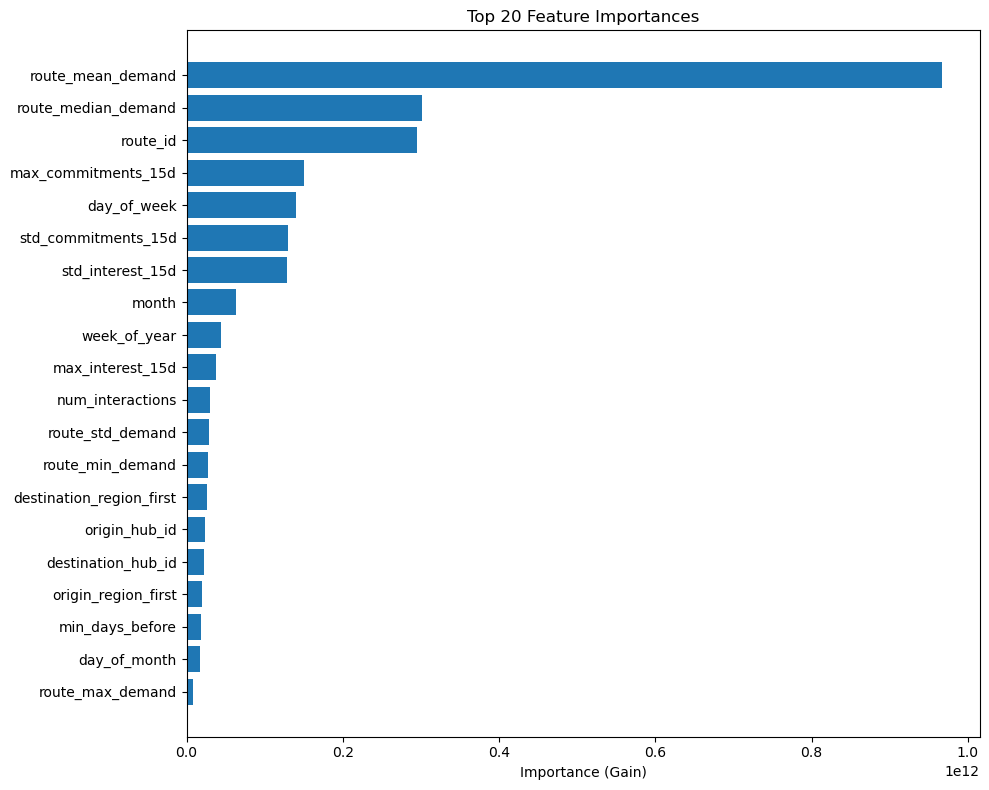

In [36]:

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

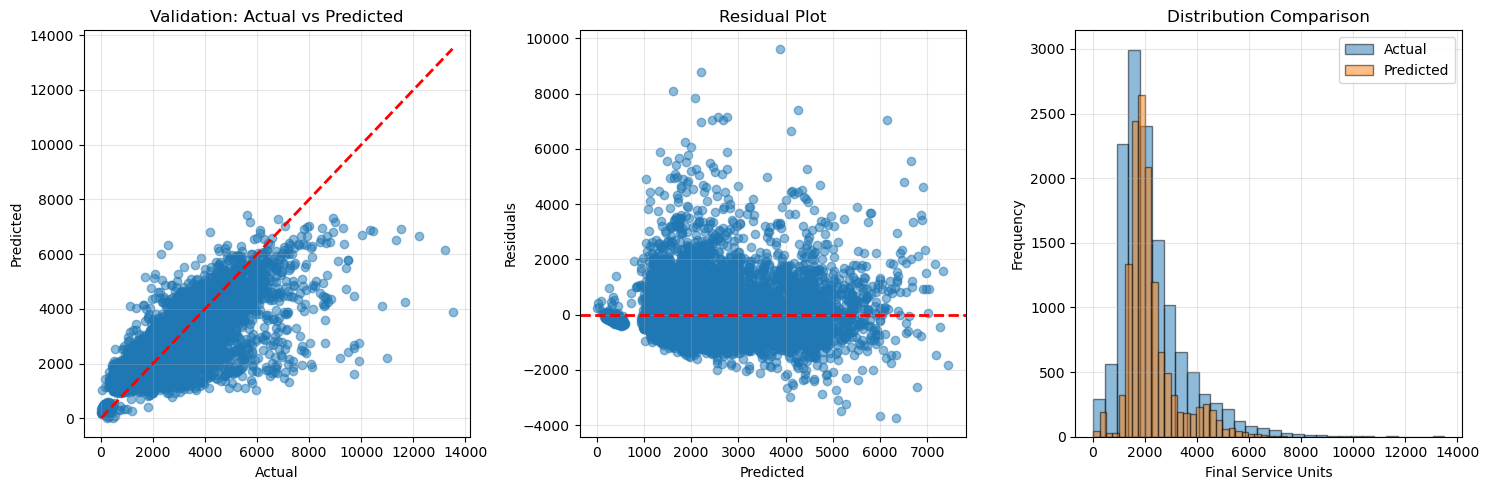


Sample Predictions:
   Actual    Predicted   Difference
0    1996  2937.627797  -941.627797
1    5116  2936.331781  2179.668219
2    7140  3814.981994  3325.018006
3    5415  4053.025214  1361.974786
4    2658  3324.540468  -666.540468
5    6315  4705.878294  1609.121706
6    3336  4397.894861 -1061.894861
7    7131  5030.061640  2100.938360
8    4062  4653.480099  -591.480099
9    7208  4671.089266  2536.910734


In [37]:

plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation: Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
plt.subplot(1, 3, 2)
residuals = y_val - y_pred_val
plt.scatter(y_pred_val, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# Plot 3: Distribution comparison
plt.subplot(1, 3, 3)
plt.hist(y_val, bins=30, alpha=0.5, label='Actual', edgecolor='black')
plt.hist(y_pred_val, bins=30, alpha=0.5, label='Predicted', edgecolor='black')
plt.xlabel('Final Service Units')
plt.ylabel('Frequency')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print sample predictions
print("\nSample Predictions:")
sample_df = pd.DataFrame({
    'Actual': y_val.values[:10],
    'Predicted': y_pred_val[:10],
    'Difference': y_val.values[:10] - y_pred_val[:10]
})
print(sample_df)


Prediction statistics:
Min: 42.03
Max: 6971.30
Mean: 1983.81
Median: 1726.56


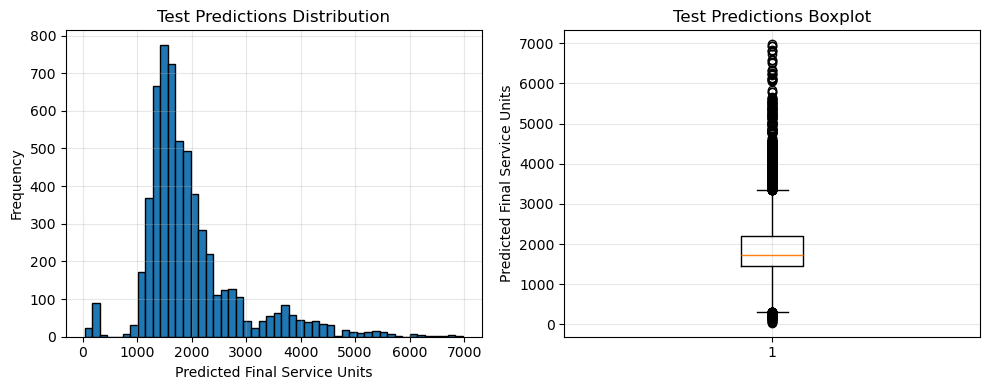

In [38]:

test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

test_predictions = np.maximum(test_predictions, 0)

print(f"\nPrediction statistics:")
print(f"Min: {test_predictions.min():.2f}")
print(f"Max: {test_predictions.max():.2f}")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Median: {np.median(test_predictions):.2f}")

# Plot prediction distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, edgecolor='black')
plt.xlabel('Predicted Final Service Units')
plt.ylabel('Frequency')
plt.title('Test Predictions Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(test_predictions)
plt.ylabel('Predicted Final Service Units')
plt.title('Test Predictions Boxplot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:

test_predictions_rounded = np.round(test_predictions).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'service_key': test['service_key'],
    'final_service_units': test_predictions_rounded
})

# Verify submission format matches sample
print("Submission shape:", submission.shape)
print("Sample submission shape:", sample_sub.shape)
print("\nSubmission columns:", submission.columns.tolist())
print("Sample submission columns:", sample_sub.columns.tolist())

# Check for any issues
print("\n🔍 Submission Validation:")
print(f"✓ Total predictions: {len(submission)}")
print(f"✓ Missing values: {submission.isnull().sum().sum()}")
print(f"✓ Negative values: {(submission['final_service_units'] < 0).sum()}")
print(f"✓ Service keys match: {set(submission['service_key']) == set(test['service_key'])}")

# Show before/after rounding comparison
print("\n📊 Rounding Impact:")
print(f"Before rounding - Mean: {test_predictions.mean():.2f}, Min: {test_predictions.min():.2f}, Max: {test_predictions.max():.2f}")
print(f"After rounding  - Mean: {test_predictions_rounded.mean():.2f}, Min: {test_predictions_rounded.min()}, Max: {test_predictions_rounded.max()}")

# Show sample
print("\n📋 Sample submission:")
print(submission.head(10))

# Save submission
submission.to_csv('mornsubmission.csv', index=False)
print("\n✅ Submission file saved as 'submission.csv'!")

Submission shape: (5900, 2)
Sample submission shape: (5900, 2)

Submission columns: ['service_key', 'final_service_units']
Sample submission columns: ['service_key', 'final_service_units']

🔍 Submission Validation:
✓ Total predictions: 5900
✓ Missing values: 0
✓ Negative values: 0
✓ Service keys match: True

📊 Rounding Impact:
Before rounding - Mean: 1983.81, Min: 42.03, Max: 6971.30
After rounding  - Mean: 1983.81, Min: 42, Max: 6971

📋 Sample submission:
        service_key  final_service_units
0  2025-02-11_46_45                 3729
1  2025-01-20_17_23                 1449
2  2025-01-08_02_14                 1291
3  2025-01-08_08_47                 1279
4  2025-01-08_09_46                 3791
5  2025-01-21_45_05                 1607
6  2025-02-26_47_08                 1325
7  2025-01-03_02_19                 2537
8  2025-02-11_02_30                 1696
9  2025-01-25_05_45                 1788

✅ Submission file saved as 'submission.csv'!


In [70]:
print("--"*74)







print("OVER")

----------------------------------------------------------------------------------------------------------------------------------------------------
OVER


In [41]:
'''

best_score = val_rmse
best_params = params.copy()

for lr in [0.03, 0.05, 0.1]:
    for num_leaves in [15, 31, 63]:
        test_params = params.copy()
        test_params['learning_rate'] = lr
        test_params['num_leaves'] = num_leaves
        
        model_test = lgb.train(
            test_params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_val],
            valid_names=['valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred_test = model_test.predict(X_val, num_iteration=model_test.best_iteration)
        test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))
        
        if test_rmse < best_score:
            best_score = test_rmse
            best_params = test_params.copy()
            print(f" New best! LR={lr}, leaves={num_leaves}, RMSE={test_rmse:.4f}")

print(best_params)
print(f"Best validation RMSE: {best_score:.4f}")'''

'\n\nbest_score = val_rmse\nbest_params = params.copy()\n\nfor lr in [0.03, 0.05, 0.1]:\n    for num_leaves in [15, 31, 63]:\n        test_params = params.copy()\n        test_params[\'learning_rate\'] = lr\n        test_params[\'num_leaves\'] = num_leaves\n        \n        model_test = lgb.train(\n            test_params,\n            lgb_train,\n            num_boost_round=1000,\n            valid_sets=[lgb_val],\n            valid_names=[\'valid\'],\n            callbacks=[\n                lgb.early_stopping(stopping_rounds=50),\n                lgb.log_evaluation(period=0)\n            ]\n        )\n        \n        y_pred_test = model_test.predict(X_val, num_iteration=model_test.best_iteration)\n        test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))\n        \n        if test_rmse < best_score:\n            best_score = test_rmse\n            best_params = test_params.copy()\n            print(f" New best! LR={lr}, leaves={num_leaves}, RMSE={test_rmse:.4f}")\n\npri

In [42]:
'''print("\n" + "="*70)
print("RANDOM HYPERPARAMETER SEARCH (FASTER & SMARTER)")
print("="*70)

import random
from datetime import datetime

# Define parameter ranges
param_ranges = {
    'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
    'num_leaves': [7, 15, 31, 63, 127, 255],
    'max_depth': [-1, 3, 5, 7, 10, 15, 20],
    'min_child_samples': [5, 10, 15, 20, 30, 50, 100],
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 3, 5, 7, 10],
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'reg_lambda': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'min_gain_to_split': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
    'subsample_for_bin': [100000, 200000, 300000, 500000],
    'min_data_in_leaf': [10, 20, 30, 50, 100]
}

# Base parameters
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'n_jobs': -1,
    'random_state': 42
}

# Number of random combinations to try
n_iterations = 200  # Try 200 random combinations (adjust as needed)

print(f"\nTrying {n_iterations} random parameter combinations...")
print(f"Expected time: ~{n_iterations * 0.5:.0f}-{n_iterations * 2:.0f} minutes\n")

best_score = float('inf')
best_params = None
best_model = None
results = []

start_time = datetime.now()

print(f"{'Iter':<6} {'LR':<8} {'Leaves':<7} {'Depth':<6} {'RMSE':<10} {'Iteration':<10} {'Time':<8} {'Status'}")
print("-" * 85)

for i in range(n_iterations):
    # Randomly sample parameters
    test_params = base_params.copy()
    test_params.update({
        'learning_rate': random.choice(param_ranges['learning_rate']),
        'num_leaves': random.choice(param_ranges['num_leaves']),
        'max_depth': random.choice(param_ranges['max_depth']),
        'min_child_samples': random.choice(param_ranges['min_child_samples']),
        'feature_fraction': random.choice(param_ranges['feature_fraction']),
        'bagging_fraction': random.choice(param_ranges['bagging_fraction']),
        'bagging_freq': random.choice(param_ranges['bagging_freq']),
        'reg_alpha': random.choice(param_ranges['reg_alpha']),
        'reg_lambda': random.choice(param_ranges['reg_lambda']),
        'min_gain_to_split': random.choice(param_ranges['min_gain_to_split']),
        'subsample_for_bin': random.choice(param_ranges['subsample_for_bin']),
        'min_data_in_leaf': random.choice(param_ranges['min_data_in_leaf'])
    })
    
    try:
        iter_start = datetime.now()
        
        # Train model
        model_test = lgb.train(
            test_params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_val],
            valid_names=['valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)
            ]
        )
        
        # Evaluate
        y_pred_test = model_test.predict(X_val, num_iteration=model_test.best_iteration)
        test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))
        
        iter_time = (datetime.now() - iter_start).total_seconds()
        
        # Store result
        result = test_params.copy()
        result['rmse'] = test_rmse
        result['best_iteration'] = model_test.best_iteration
        result['time'] = iter_time
        results.append(result)
        
        # Check if best
        status = ""
        if test_rmse < best_score:
            best_score = test_rmse
            best_params = test_params.copy()
            best_model = model_test
            status = "🌟 NEW BEST!"
        
        print(f"{i+1:<6} {test_params['learning_rate']:<8.4f} {test_params['num_leaves']:<7} {test_params['max_depth']:<6} {test_rmse:<10.4f} {model_test.best_iteration:<10} {iter_time:<8.2f}s {status}")
        
        # Progress update every 20 iterations
        if (i + 1) % 20 == 0:
            elapsed = (datetime.now() - start_time).total_seconds()
            avg_time = elapsed / (i + 1)
            remaining = (n_iterations - i - 1) * avg_time
            print(f"    📊 Progress: {i+1}/{n_iterations} ({(i+1)/n_iterations*100:.1f}%) | Best: {best_score:.4f} | ETA: {remaining/60:.1f}min")
    
    except Exception as e:
        print(f"❌ {i+1:<6} Error: {str(e)[:50]}")
        continue

print("\n" + "="*70)
print("RANDOM SEARCH COMPLETED!")
print("="*70)
print(f"\nTotal time: {(datetime.now() - start_time).total_seconds()/60:.2f} minutes")

print(f"\n🏆 BEST PARAMETERS FOUND:")
print("-" * 70)
for param, value in sorted(best_params.items()):
    print(f"{param:<25}: {value}")
print(f"\n🎯 Best Validation RMSE: {best_score:.4f}")
print(f"🔄 Best Iteration: {best_model.best_iteration}")

# Save results to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('rmse')

print("\n📊 TOP 10 PARAMETER COMBINATIONS:")
print(results_df[['learning_rate', 'num_leaves', 'max_depth', 'rmse', 'best_iteration']].head(10))

# Save to CSV
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("\n✅ Full results saved to 'hyperparameter_tuning_results.csv'")'''

'print("\n" + "="*70)\nprint("RANDOM HYPERPARAMETER SEARCH (FASTER & SMARTER)")\nprint("="*70)\n\nimport random\nfrom datetime import datetime\n\n# Define parameter ranges\nparam_ranges = {\n    \'learning_rate\': [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2],\n    \'num_leaves\': [7, 15, 31, 63, 127, 255],\n    \'max_depth\': [-1, 3, 5, 7, 10, 15, 20],\n    \'min_child_samples\': [5, 10, 15, 20, 30, 50, 100],\n    \'feature_fraction\': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n    \'bagging_fraction\': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n    \'bagging_freq\': [0, 1, 3, 5, 7, 10],\n    \'reg_alpha\': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],\n    \'reg_lambda\': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],\n    \'min_gain_to_split\': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0],\n    \'subsample_for_bin\': [100000, 200000, 300000, 500000],\n    \'min_data_in_leaf\': [10, 20, 30, 50, 100]\n}\n\n# Base parameters\nbase_params = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    

In [55]:
'''print("\n" + "="*70)
print("FEATURE SELECTION - KEEPING TOP FEATURES ONLY")
print("="*70)

# Get feature importance from your trained model
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Calculate cumulative importance
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df['cumulative_percentage'] = (
    feature_importance_df['cumulative_importance'] / feature_importance_df['importance'].sum() * 100
)

print("\n📊 Top 20 Features by Importance:")
print(feature_importance_df[['feature', 'importance', 'cumulative_percentage']].head(20))

# Select features contributing to 95% of importance
threshold_pct = 95
selected_features = feature_importance_df[
    feature_importance_df['cumulative_percentage'] <= threshold_pct
]['feature'].tolist()

# Add one more feature to cross the threshold
if len(selected_features) < len(feature_importance_df):
    next_feature = feature_importance_df.iloc[len(selected_features)]['feature']
    selected_features.append(next_feature)

print(f"\n✅ Selected features: {len(selected_features)}/{len(feature_cols)}")
print(f"📉 Removed features: {len(feature_cols) - len(selected_features)}")

print("\n🗑️  Removed features:")
removed_features = [f for f in feature_cols if f not in selected_features]
for i, feat in enumerate(removed_features, 1):
    imp = feature_importance_df[feature_importance_df['feature'] == feat]['importance'].values[0]
    print(f"{i}. {feat} (importance: {imp:.2e})")

print("\n✨ Selected features list:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i}. {feat}")'''


FEATURE SELECTION - KEEPING TOP FEATURES ONLY

📊 Top 20 Features by Importance:
                     feature    importance  cumulative_percentage
29         route_mean_demand  9.672126e+11              38.329937
30       route_median_demand  3.019097e+11              50.294403
11                  route_id  2.951291e+11              61.990155
12       max_commitments_15d  1.502482e+11              67.944384
2                day_of_week  1.403106e+11              73.504790
14       std_commitments_15d  1.297955e+11              78.648492
18          std_interest_15d  1.288811e+11              83.755958
5                      month  6.380229e+10              86.284397
4               week_of_year  4.461964e+10              88.052641
16          max_interest_15d  3.701337e+10              89.519454
27          num_interactions  2.965520e+10              90.694669
31          route_std_demand  2.893556e+10              91.841364
33          route_min_demand  2.748819e+10              92.93

In [56]:
'''print("\n" + "="*70)
print("RETRAINING WITH SELECTED FEATURES")
print("="*70)

# Use original train_processed (NO outlier handling)
train_processed_sorted = train_processed.sort_values('service_date')
split_idx = int(len(train_processed_sorted) * 0.8)

train_set = train_processed_sorted.iloc[:split_idx].copy()
val_set = train_processed_sorted.iloc[split_idx:].copy()

# Extract selected features only
X_train_selected = train_set[selected_features].copy()
y_train_selected = train_set['final_service_units']

X_val_selected = val_set[selected_features].copy()
y_val_selected = val_set['final_service_units']

X_test_selected = test_processed[selected_features].copy()

# Encode categorical variables
print("\n🔄 Encoding categorical variables...")
categorical_cols_to_encode = X_train_selected.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols_to_encode:
    le = LabelEncoder()
    
    # Fit on all data (train + val + test)
    all_values = pd.concat([
        X_train_selected[col],
        X_val_selected[col],
        X_test_selected[col]
    ]).astype(str)
    
    le.fit(all_values)
    
    # Transform
    X_train_selected[col] = le.transform(X_train_selected[col].astype(str))
    X_val_selected[col] = le.transform(X_val_selected[col].astype(str))
    X_test_selected[col] = le.transform(X_test_selected[col].astype(str))
    
    label_encoders[col] = le
    print(f"✓ Encoded {col}")

# Update categorical features for LightGBM
categorical_features_selected = [f for f in categorical_features if f in selected_features]

print(f"\n📊 Data prepared:")
print(f"Features: {len(selected_features)}")
print(f"Categorical: {len(categorical_features_selected)}")
print(f"Train samples: {len(X_train_selected)}")
print(f"Val samples: {len(X_val_selected)}")
print(f"Test samples: {len(X_test_selected)}")

# Create LightGBM datasets
lgb_train_selected = lgb.Dataset(
    X_train_selected,
    y_train_selected,
    categorical_feature=categorical_features_selected
)

lgb_val_selected = lgb.Dataset(
    X_val_selected,
    y_val_selected,
    categorical_feature=categorical_features_selected,
    reference=lgb_train_selected
)

# Train with best parameters
print("\n🔨 Training model with selected features...")
model_selected = lgb.train(
    best_params,
    lgb_train_selected,
    num_boost_round=2500,
    valid_sets=[lgb_train_selected, lgb_val_selected],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),
        lgb.log_evaluation(period=100)
    ]
)

# Evaluate
y_pred_train_selected = model_selected.predict(X_train_selected, num_iteration=model_selected.best_iteration)
y_pred_val_selected = model_selected.predict(X_val_selected, num_iteration=model_selected.best_iteration)

train_rmse_selected = np.sqrt(mean_squared_error(y_train_selected, y_pred_train_selected))
val_rmse_selected = np.sqrt(mean_squared_error(y_val_selected, y_pred_val_selected))

train_mae_selected = mean_absolute_error(y_train_selected, y_pred_train_selected)
val_mae_selected = mean_absolute_error(y_val_selected, y_pred_val_selected)

print(f"\n📊 MODEL PERFORMANCE:")
print(f"{'='*50}")
print(f"Train RMSE: {train_rmse_selected:.4f}")
print(f"Val RMSE:   {val_rmse_selected:.4f}")
print(f"Train MAE:  {train_mae_selected:.4f}")
print(f"Val MAE:    {val_mae_selected:.4f}")
print(f"Best Iteration: {model_selected.best_iteration}")'''


RETRAINING WITH SELECTED FEATURES

🔄 Encoding categorical variables...
✓ Encoded route_id
✓ Encoded destination_region_first

📊 Data prepared:
Features: 16
Categorical: 6
Train samples: 53760
Val samples: 13440
Test samples: 5900

🔨 Training model with selected features...
Training until validation scores don't improve for 150 rounds
[100]	train's rmse: 696.874	valid's rmse: 939.484
[200]	train's rmse: 565.587	valid's rmse: 848.521
[300]	train's rmse: 506.345	valid's rmse: 799.36
[400]	train's rmse: 468.283	valid's rmse: 775.193
[500]	train's rmse: 444.243	valid's rmse: 769.88
[600]	train's rmse: 428.24	valid's rmse: 764.001
[700]	train's rmse: 417.175	valid's rmse: 762.361
[800]	train's rmse: 408.087	valid's rmse: 763.119
Early stopping, best iteration is:
[719]	train's rmse: 415.167	valid's rmse: 762.068

📊 MODEL PERFORMANCE:
Train RMSE: 415.1665
Val RMSE:   762.0681
Train MAE:  286.0543
Val MAE:    555.4371
Best Iteration: 719


In [57]:
'''print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison = pd.DataFrame({
    'Metric': ['Val RMSE', 'Val MAE', 'Features', 'Best Iteration'],
    'Original (All Features)': [val_rmse, val_mae, len(feature_cols), model.best_iteration],
    'Selected Features': [val_rmse_selected, val_mae_selected, len(selected_features), model_selected.best_iteration]
})

print(comparison.to_string(index=False))

# Calculate improvement/change
rmse_change = ((val_rmse - val_rmse_selected) / val_rmse) * 100
feature_reduction = ((len(feature_cols) - len(selected_features)) / len(feature_cols)) * 100

print(f"\n📈 Changes:")
print(f"RMSE Change: {rmse_change:+.2f}% {'(Better!)' if rmse_change > 0 else '(Worse)'}")
print(f"Features Reduced: {feature_reduction:.1f}%")

# Show predictions
print("\n📋 Sample Predictions Comparison:")
sample_comparison = pd.DataFrame({
    'Actual': y_val_selected.values[:15],
    'Original_Pred': model.predict(X_val[feature_cols].iloc[:15], num_iteration=model.best_iteration),
    'Selected_Pred': y_pred_val_selected[:15]
})
sample_comparison['Original_Error'] = sample_comparison['Actual'] - sample_comparison['Original_Pred']
sample_comparison['Selected_Error'] = sample_comparison['Actual'] - sample_comparison['Selected_Pred']

print(sample_comparison.to_string(index=True))'''


MODEL COMPARISON
        Metric  Original (All Features)  Selected Features
      Val RMSE               835.173197         762.068092
       Val MAE               550.229278         555.437103
      Features                35.000000          16.000000
Best Iteration               999.000000         719.000000

📈 Changes:
RMSE Change: +8.75% (Better!)
Features Reduced: 54.3%

📋 Sample Predictions Comparison:
    Actual  Original_Pred  Selected_Pred  Original_Error  Selected_Error
0     3045    2937.627797    2153.174000      107.372203      891.826000
1     2580    2936.331781    2149.213944     -356.331781      430.786056
2     3075    3814.981994    2502.514263     -739.981994      572.485737
3     1720    4053.025214    1971.663265    -2333.025214     -251.663265
4     2960    3324.540468    1917.413889     -364.540468     1042.586111
5      135    4705.878294     494.117620    -4570.878294     -359.117620
6     2965    4397.894861    1832.661252    -1432.894861     1132.338748
7  

In [58]:
'''print("\n" + "="*70)
print("GENERATING FINAL SUBMISSION")
print("="*70)

# Make predictions on test set
test_predictions = model_selected.predict(X_test_selected, num_iteration=model_selected.best_iteration)

# Post-process
test_predictions = np.maximum(test_predictions, 0)  # No negatives
test_predictions = np.round(test_predictions).astype(int)  # Round to integers

print(f"\n📊 Test Predictions Statistics:")
print(f"Min:    {test_predictions.min()}")
print(f"Max:    {test_predictions.max()}")
print(f"Mean:   {test_predictions.mean():.2f}")
print(f"Median: {np.median(test_predictions):.2f}")

# Create submission
submission = pd.DataFrame({
    'service_key': test['service_key'],
    'final_service_units': test_predictions
})

# Validation
print("\n🔍 Submission Validation:")
print(f"✓ Total predictions: {len(submission)}")
print(f"✓ Missing values: {submission.isnull().sum().sum()}")
print(f"✓ Negative values: {(submission['final_service_units'] < 0).sum()}")
print(f"✓ Keys match: {set(submission['service_key']) == set(test['service_key'])}")

print("\n📋 Sample submission:")
print(submission.head(10))

# Save
submission.to_csv('submission_final.csv', index=False)
print("\n✅ Final submission saved as 'submission_final.csv'!")

print("\n🎯 Summary:")
print(f"Used {len(selected_features)} features (removed {len(feature_cols) - len(selected_features)})")
print(f"Validation RMSE: {val_rmse_selected:.4f}")
print(f"Ready to submit!")'''


GENERATING FINAL SUBMISSION

📊 Test Predictions Statistics:
Min:    137
Max:    6001
Mean:   1980.47
Median: 1719.00

🔍 Submission Validation:
✓ Total predictions: 5900
✓ Missing values: 0
✓ Negative values: 0
✓ Keys match: True

📋 Sample submission:
        service_key  final_service_units
0  2025-02-11_46_45                 3705
1  2025-01-20_17_23                 1405
2  2025-01-08_02_14                 1311
3  2025-01-08_08_47                 1307
4  2025-01-08_09_46                 3810
5  2025-01-21_45_05                 1598
6  2025-02-26_47_08                 1309
7  2025-01-03_02_19                 2495
8  2025-02-11_02_30                 1739
9  2025-01-25_05_45                 1781

✅ Final submission saved as 'submission_final.csv'!

🎯 Summary:
Used 16 features (removed 19)
Validation RMSE: 762.0681
Ready to submit!


In [59]:
'''print("\n" + "="*70)
print("BUILDING ENSEMBLE MODEL")
print("="*70)

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# We already have model from Step 17 (LightGBM)
# Let's train 3 more models and ensemble them

# Prepare data (use your existing split)
train_processed_sorted = train_processed.sort_values('service_date')
split_idx = int(len(train_processed_sorted) * 0.8)

train_set = train_processed_sorted.iloc[:split_idx].copy()
val_set = train_processed_sorted.iloc[split_idx:].copy()

X_train = train_set[feature_cols].copy()
y_train = train_set['final_service_units']

X_val = val_set[feature_cols].copy()
y_val = val_set['final_service_units']

X_test = test_processed[feature_cols].copy()

# Encode categorical variables
print("\n🔄 Encoding categorical variables...")
categorical_cols_to_encode = X_train.select_dtypes(include=['object']).columns.tolist()

label_encoders_ensemble = {}
for col in categorical_cols_to_encode:
    le = LabelEncoder()
    all_values = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    le.fit(all_values)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    label_encoders_ensemble[col] = le

print("✅ Encoding complete!")

# Store predictions from each model
train_predictions = {}
val_predictions = {}
test_predictions = {}

print("\n" + "="*70)
print("MODEL 1: LightGBM (Already Trained)")
print("="*70)

# Use existing LightGBM model from Step 17
lgb_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
lgb_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
lgb_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

lgb_val_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_pred))
print(f"LightGBM Val RMSE: {lgb_val_rmse:.4f}")

train_predictions['lgb'] = lgb_train_pred
val_predictions['lgb'] = lgb_val_pred
test_predictions['lgb'] = lgb_test_pred'''


BUILDING ENSEMBLE MODEL

🔄 Encoding categorical variables...
✅ Encoding complete!

MODEL 1: LightGBM (Already Trained)
LightGBM Val RMSE: 759.6551


In [61]:
'''print("\n" + "="*70)
print("MODEL 2: Training XGBoost")
print("="*70)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 100  # Move this parameter here
}

# Create model with all parameters including early_stopping_rounds
xgb_model = xgb.XGBRegressor(**xgb_params)

print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
    # Remove early_stopping_rounds from fit() method
)

xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
print(f"\n✅ XGBoost Val RMSE: {xgb_val_rmse:.4f}")

train_predictions['xgb'] = xgb_train_pred
val_predictions['xgb'] = xgb_val_pred
test_predictions['xgb'] = xgb_test_pred'''


MODEL 2: Training XGBoost
Training XGBoost...
[0]	validation_0-rmse:1072.21428	validation_1-rmse:1232.54501
[100]	validation_0-rmse:435.87619	validation_1-rmse:806.45090
[194]	validation_0-rmse:390.66003	validation_1-rmse:820.88742

✅ XGBoost Val RMSE: 804.2791


In [63]:
#!pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB 220.2 kB/s eta 0:07:46
   ---------------------------------------- 0.1/102.5 MB 365.7 kB/s eta 0:04:41
   ---------------------------------------- 0.1/102.5 MB 476.3 kB/s eta 0:03:35
   ---------------------------------------- 0.2/102.5 MB 656.4 kB/s eta 0:02:36
   ---------------------------------------- 0.2/102.5 MB 838.1 kB/s eta 0:02:02
   ---------------------------------------- 0.2/102.5 MB 838.1 kB/s eta 0:02:02
   ---------------------------------------- 0.3/102.5 MB 846.5 kB/s eta 0:02:01
   ---------------------------------------- 0.4/102.5 MB 897.8 kB/s eta 0:01:54
   ---------------------------------------- 0.5/102.5 MB 984.6 kB/s eta 0:01:44
   ---------------------------------------- 0.6/102.5 MB 1.1 MB/s e

In [64]:
'''print("\n" + "="*70)
print("MODEL 3: Training CatBoost")
print("="*70)

try:
    from catboost import CatBoostRegressor
    
    # Identify categorical features for CatBoost
    cat_features_idx = [i for i, col in enumerate(feature_cols) if col in categorical_features]
    
    catboost_params = {
        'iterations': 2000,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3,
        'random_seed': 42,
        'verbose': 100,
        'early_stopping_rounds': 100,
        'task_type': 'CPU'
    }
    
    catboost_model = CatBoostRegressor(**catboost_params)
    
    print("Training CatBoost...")
    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features_idx,
        verbose=100
    )
    
    catboost_train_pred = catboost_model.predict(X_train)
    catboost_val_pred = catboost_model.predict(X_val)
    catboost_test_pred = catboost_model.predict(X_test)
    
    catboost_val_rmse = np.sqrt(mean_squared_error(y_val, catboost_val_pred))
    print(f"\n✅ CatBoost Val RMSE: {catboost_val_rmse:.4f}")
    
    train_predictions['catboost'] = catboost_train_pred
    val_predictions['catboost'] = catboost_val_pred
    test_predictions['catboost'] = catboost_test_pred
    
except ImportError:
    print("⚠️ CatBoost not installed. Skipping. (pip install catboost)")
    print("Ensemble will use LightGBM + XGBoost only")'''


MODEL 3: Training CatBoost
Training CatBoost...
0:	learn: 1077.3212462	test: 1237.6493582	best: 1237.6493582 (0)	total: 327ms	remaining: 10m 52s
100:	learn: 510.6019591	test: 793.4136328	best: 793.4136328 (100)	total: 16.5s	remaining: 5m 9s
200:	learn: 460.0321877	test: 778.8984753	best: 777.9579664 (185)	total: 35.5s	remaining: 5m 17s
300:	learn: 434.0750221	test: 785.1166739	best: 776.4507705 (248)	total: 53s	remaining: 4m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 776.4507705
bestIteration = 248

Shrink model to first 249 iterations.

✅ CatBoost Val RMSE: 776.4508


In [65]:
'''print("\n" + "="*70)
print("MODEL 4: Training Random Forest")
print("="*70)

rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}

rf_model = RandomForestRegressor(**rf_params)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

rf_val_rmse = np.sqrt(mean_squared_error(y_val, rf_val_pred))
print(f"\n✅ Random Forest Val RMSE: {rf_val_rmse:.4f}")

train_predictions['rf'] = rf_train_pred
val_predictions['rf'] = rf_val_pred
test_predictions['rf'] = rf_test_pred'''


MODEL 4: Training Random Forest
Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



✅ Random Forest Val RMSE: 818.8086


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


In [66]:
'''print("\n" + "="*70)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*70)

model_performance = {}

for model_name in val_predictions.keys():
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions[model_name]))
    mae = mean_absolute_error(y_val, val_predictions[model_name])
    model_performance[model_name] = {'RMSE': rmse, 'MAE': mae}

performance_df = pd.DataFrame(model_performance).T
performance_df = performance_df.sort_values('RMSE')

print(performance_df)

print(f"\n🏆 Best Individual Model: {performance_df.index[0]} with RMSE: {performance_df['RMSE'].iloc[0]:.4f}")'''


INDIVIDUAL MODEL PERFORMANCE
                RMSE         MAE
lgb       759.655079  529.415701
catboost  776.450770  537.577021
xgb       804.279091  575.589109
rf        818.808618  582.628262

🏆 Best Individual Model: lgb with RMSE: 759.6551


In [67]:
'''print("\n" + "="*70)
print("ENSEMBLE METHOD 2: WEIGHTED AVERAGE")
print("="*70)

# Calculate weights based on validation RMSE (inverse of RMSE)
weights = {}
total_inv_rmse = 0

for model_name in val_predictions.keys():
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions[model_name]))
    inv_rmse = 1 / rmse
    weights[model_name] = inv_rmse
    total_inv_rmse += inv_rmse

# Normalize weights
for model_name in weights.keys():
    weights[model_name] = weights[model_name] / total_inv_rmse

print("📊 Model Weights:")
for model_name, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name:<12}: {weight:.4f} ({weight*100:.1f}%)")

# Weighted predictions
ensemble_val_pred_weighted = sum(
    val_predictions[model_name] * weights[model_name] 
    for model_name in val_predictions.keys()
)

ensemble_test_pred_weighted = sum(
    test_predictions[model_name] * weights[model_name] 
    for model_name in test_predictions.keys()
)

ensemble_weighted_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred_weighted))
ensemble_weighted_mae = mean_absolute_error(y_val, ensemble_val_pred_weighted)

print(f"\n✅ Ensemble (Weighted) Val RMSE: {ensemble_weighted_rmse:.4f}")
print(f"✅ Ensemble (Weighted) Val MAE: {ensemble_weighted_mae:.4f}")

improvement_weighted = ((performance_df['RMSE'].iloc[0] - ensemble_weighted_rmse) / performance_df['RMSE'].iloc[0]) * 100
print(f"\n📈 Improvement over best single model: {improvement_weighted:.2f}%")'''


ENSEMBLE METHOD 2: WEIGHTED AVERAGE
📊 Model Weights:
lgb         : 0.2597 (26.0%)
catboost    : 0.2541 (25.4%)
xgb         : 0.2453 (24.5%)
rf          : 0.2409 (24.1%)

✅ Ensemble (Weighted) Val RMSE: 773.5480
✅ Ensemble (Weighted) Val MAE: 542.9620

📈 Improvement over best single model: -1.83%


In [68]:
'''print("\n" + "="*70)
print("ENSEMBLE METHOD 3: STACKING (META-LEARNER)")
print("="*70)

# Create meta-features from base model predictions
X_train_meta = np.column_stack([train_predictions[name] for name in train_predictions.keys()])
X_val_meta = np.column_stack([val_predictions[name] for name in val_predictions.keys()])
X_test_meta = np.column_stack([test_predictions[name] for name in test_predictions.keys()])

print(f"Meta-features shape: {X_train_meta.shape}")

# Train meta-learner (Ridge Regression works well)
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(X_train_meta, y_train)

# Meta-learner predictions
ensemble_val_pred_stacking = meta_learner.predict(X_val_meta)
ensemble_test_pred_stacking = meta_learner.predict(X_test_meta)

ensemble_stacking_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred_stacking))
ensemble_stacking_mae = mean_absolute_error(y_val, ensemble_val_pred_stacking)

print(f"\n✅ Ensemble (Stacking) Val RMSE: {ensemble_stacking_rmse:.4f}")
print(f"✅ Ensemble (Stacking) Val MAE: {ensemble_stacking_mae:.4f}")

print("\n📊 Meta-learner coefficients:")
for i, model_name in enumerate(train_predictions.keys()):
    print(f"{model_name:<12}: {meta_learner.coef_[i]:.4f}")

improvement_stacking = ((performance_df['RMSE'].iloc[0] - ensemble_stacking_rmse) / performance_df['RMSE'].iloc[0]) * 100
print(f"\n📈 Improvement over best single model: {improvement_stacking:.2f}%")'''


ENSEMBLE METHOD 3: STACKING (META-LEARNER)
Meta-features shape: (53760, 4)

✅ Ensemble (Stacking) Val RMSE: 791.5372
✅ Ensemble (Stacking) Val MAE: 557.2327

📊 Meta-learner coefficients:
lgb         : 0.7649
xgb         : -0.6058
catboost    : -0.1228
rf          : 0.9828

📈 Improvement over best single model: -4.20%


In [69]:
'''print("\n" + "="*70)
print("GENERATING FINAL SUBMISSION")
print("="*70)

# Choose the best ensemble method
# Usually weighted or stacking performs best
print(f"Using: Ensemble (Stacking) for final submission")
final_test_predictions = ensemble_test_pred_stacking

# Post-process
final_test_predictions = np.maximum(final_test_predictions, 0)
final_test_predictions = np.round(final_test_predictions).astype(int)

print(f"\n📊 Final Predictions Statistics:")
print(f"Min:    {final_test_predictions.min()}")
print(f"Max:    {final_test_predictions.max()}")
print(f"Mean:   {final_test_predictions.mean():.2f}")
print(f"Median: {np.median(final_test_predictions):.2f}")

# Create submission
submission_ensemble = pd.DataFrame({
    'service_key': test['service_key'],
    'final_service_units': final_test_predictions
})

# Save
submission_ensemble.to_csv('submission_ensemble.csv', index=False)
print("\n✅ Ensemble submission saved as 'submission_ensemble.csv'!")

print("\n" + "="*70)
print("🎉 ENSEMBLE PIPELINE COMPLETE!")
print("="*70)
print(f"Best validation RMSE: {best_rmse:.4f}")
print(f"Using {len(train_predictions)} models in ensemble")
print(f"Ready to submit!")'''


GENERATING FINAL SUBMISSION
Using: Ensemble (Stacking) for final submission

📊 Final Predictions Statistics:
Min:    23
Max:    6523
Mean:   1980.23
Median: 1716.00

✅ Ensemble submission saved as 'submission_ensemble.csv'!

🎉 ENSEMBLE PIPELINE COMPLETE!


NameError: name 'best_rmse' is not defined